In [1]:
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


Using TensorFlow backend.


In [2]:
data = pd.read_csv('twitter.csv', encoding='latin-1', names=["Target", "Ids", "Date", "Flag", "User", "Text"])

In [3]:
#del data['Flag']

In [4]:
data.sample(10)

,Target,Ids,Date,Flag,User,Text
638312,0,2234423190,Thu Jun 18 23:01:44 PDT 2009,NO_QUERY,MIRELLAELLA,alright.....i need to put the addiction to res...
1475170,4,2065854729,Sun Jun 07 09:25:22 PDT 2009,NO_QUERY,phoenix0523,"Sleep time for me, take care people and before..."
342801,0,2015330100,Wed Jun 03 04:22:15 PDT 2009,NO_QUERY,haplesshousewif,Finally got that blog post finished and up.Wou...
461296,0,2174412136,Sun Jun 14 22:30:00 PDT 2009,NO_QUERY,chiefhky29,Hey @joephus0311 this wasnt a good set (Joep...
1457291,4,2063571733,Sun Jun 07 03:12:11 PDT 2009,NO_QUERY,LaaurineJ,http://twitpic.com/6tkiq - 2nde9 : My family (l)
1237882,4,1993123555,Mon Jun 01 09:52:11 PDT 2009,NO_QUERY,tartdarling,@holydueg not much. just tryin to beat the Wor...
359469,0,2045823493,Fri Jun 05 11:17:19 PDT 2009,NO_QUERY,gpeventsfl,@pepsi Even the sunshine state doesn't have su...
430592,0,2064364662,Sun Jun 07 06:03:39 PDT 2009,NO_QUERY,jesssicaraymond,@billyraycyrus oi tell your daughter to lower ...
373535,0,2051031272,Fri Jun 05 19:44:12 PDT 2009,NO_QUERY,Yental01,I should know better than to eat sweets!
539739,0,2199521720,Tue Jun 16 17:37:17 PDT 2009,NO_QUERY,JaysBarbieDoll,@KimberlyNash @JayArguelles It's just sad in m...


In [5]:
#List the number of missing values for each column.
#Iterate through each column vector to find the # of missing values
for row in data:
    value = data[row].isnull().sum()
    print("There are", value, " missing values in column",row)

There are 0  missing values in column Target
There are 0  missing values in column Ids
There are 0  missing values in column Date
There are 0  missing values in column Flag
There are 0  missing values in column User
There are 0  missing values in column Text


In [6]:
#start cleaning refined dataset by removing duplicates
data = data.drop_duplicates(keep=False)

In [7]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
data.Target = data.Target.apply(lambda x: decode_sentiment(x))

In [9]:
data.head()

,Target,Ids,Date,Flag,User,Text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


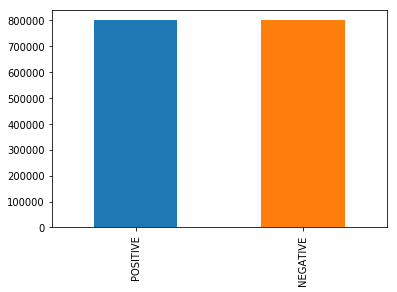

In [10]:
data['Target'].value_counts().plot('bar')

In [11]:
data['User'].value_counts()[0:10]

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
Name: User, dtype: int64

In [12]:
ten_percent = data.sample(160000)

# test = data[160000:32000]

In [101]:
ten_percent.to_csv("ten_percent_sample.csv")

In [13]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


In [14]:
X = ten_percent.iloc[:,[5]]
# X_test = test.iloc[:,[5]]


In [15]:
ten_percent.head()

,Target,Ids,Date,Flag,User,Text
432224,NEGATIVE,2064701021,Sun Jun 07 06:57:39 PDT 2009,NO_QUERY,GerryGreek,"@ThisisDavina Pretty, Ur following Luke and no..."
1178354,POSITIVE,1981566741,Sun May 31 09:25:30 PDT 2009,NO_QUERY,KristinaSummer,beautiful day to be outside listening to the b...
455046,NEGATIVE,2070806987,Sun Jun 07 18:19:48 PDT 2009,NO_QUERY,yaadayaada,@magicofpi My itunes decide to delete my music...
1259774,POSITIVE,1998188009,Mon Jun 01 18:08:15 PDT 2009,NO_QUERY,Jackienurse1,down 63 Lbs I love my band ; -) to have my 3r...
217484,NEGATIVE,1975946883,Sat May 30 16:14:55 PDT 2009,NO_QUERY,mcraddictal,Where'd everyone go? Anyone there?


In [16]:

import warnings
warnings.filterwarnings('ignore')

# Text-preprocessing
# Missing Values
num_missing_desc = ten_percent.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
ten_percent = ten_percent.dropna()

TAG_CLEANING_RE = "@\S+"
# Remove @tags
X['Text'] = X['Text'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
X['Text'] = X['Text'].map(lambda x: x.lower())

# Remove numbers
X['Text'] = X['Text'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['Text'] = X['Text'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
X['Text']  = X['Text'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
X['Text'] = X['Text'].map(lambda x: x.strip())

# Tokenize into words
X['Text'] = X['Text'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
X['Text'] = X['Text'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
# stop_words = set(stopwords.words('english'))
# X['Text'] = X['Text'].map(lambda x: [w for w in x if not w in stop_words])
    
# Word Lemmatization
lem = WordNetLemmatizer()
X['Text'] = X['Text'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
X['Text'] = X['Text'].map(lambda x: ' '.join(x))

Number of missing values: 0


In [17]:
X.head()

,Text
432224,pretty ur follow luke and not me
1178354,beautiful day to be outside listen to the bird...
455046,my itunes decide to delete my music library on...
1259774,down lbs i love my band to have my rd fill around
217484,where d everyone go anyone there


In [18]:
from pycorenlp import StanfordCoreNLP


In [19]:
nlp = StanfordCoreNLP('http://localhost:9000')


In [58]:
sentiment = []
def get_sentiment(text):
    res = nlp.annotate(text,
                       properties={'annotators': 'sentiment',
                                   'outputFormat': 'json',
                                   'timeout': 100000,
                       })
    sentiment.append(res['sentences'][0]['sentiment'])


In [59]:
a = X['Text'][0:16000]

In [60]:
for x in a[0:16000]:
    get_sentiment(x)


IndexError: list index out of range

In [61]:
len(sentiment)

490

In [96]:
nlp_run = pd.DataFrame(data = a[0:490])

In [89]:
vader = []
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    vader.append(score)


In [90]:
for x in a[0:490]:
    sentiment_analyzer_scores(x)


In [91]:
vader_score = []
for x in vader:
    da = x.get("compound", "")
    vader_score.append(da)

In [93]:
vader_sent = []
for x, va in enumerate(vader_score):
    if(va > 0.05):
        vader_sent.append('Positive') 
    if(va < 0.05 and va > -0.05):
        vader_sent.append('Neutral') 
    if(va < -0.05):
        vader_sent.append('Negative') 
    
    
    

In [95]:
len(vader_sent)

490

In [99]:
nlp_run['standford_sentiment'] = sentiment
nlp_run['Vader_sentiment'] = vader_sent

In [100]:
nlp_run.to_csv('nlp.csv')

In [121]:
import sklearn.decomposition as dec

from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english', max_df=0.98, min_df=0.01)
df_bag = count.fit_transform(X['Text'][0:1000])
feature_names = count.get_feature_names()
lda = dec.LatentDirichletAllocation(n_components=4)
lda.fit(df_bag)
n_top_words = 20
for topic_idx, topic in enumerate(lda.components_):
        print("Topic %d: " % topic_idx, end='')
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

Topic 0: miss today quot love thank feel sad like need na look great know haha start hope gon sorry enjoy tweet
Topic 1: work make want lol im night come tonight wish twitter away lose say eat tomorrow people wait hate run home
Topic 2: think like new really oh day play watch bad happy miss let check hey weekend yeah days guess know buy
Topic 3: good time day amp sleep try right home leave awesome long morning love lt wake night na week pretty soon
